### Final function

In [2]:
# not sure what to do about pudl_out - should it be an argument?
# df: iso_active_projects data
# gt_upper_capacity_threshold: 
# the highest capacity in MW that is still labeled as a gas turbine and not combined cycle
# gt_hr: gas turbine heat rate (BTU per kWh)
# cc_hr: combined cycle heat rate (BTU per kWh)
# gas_emission_factor: natural gas emissions factor in kg CO2e/mmbtu of fuel
# gt_cf_threshold: capacity at which to use a different average capacity factor for gas turbines
# heat rate source: https://www.eia.gov/electricity/annual/html/epa_08_02.html
# emissions factor source: https://github.com/grgmiller/emission-factors
def add_co2_emissions(df, 
                      pudl_out, 
                      gt_upper_capacity_threshold=100, 
                      gt_hr=11069, 
                      ct_hr=7604,
                      gas_emission_factor=53.08,
                      gt_cf_threshold=40):
    
    mcoe = pudl_out.mcoe(all_gens=True)
    gas_codes = ['CA', 'CT', 'CS', 'GT']
    mcoe_filt = mcoe[(mcoe.fuel_type_code_pudl == 'gas') 
                     & (mcoe.operational_status == 'existing') 
                     & (mcoe['operating_date'] > '2010-01-01') 
                     & (mcoe['prime_mover_code'].isin(gas_codes))]
    mcoe_filt = mcoe_filt[['prime_mover_code', 
                           'capacity_factor', 
                           'capacity_mw', 
                           'operating_date', 
                           'plant_id_eia', 
                           'report_date', 
                           'utility_name_eia', 
                           'utility_id_eia', ]]
    
    df = df[(df.resource == 'Gas') & (df.interconnection_status_lbnl == 'In Progress')]
    df['prime_mover_inferred'] = 'GT'
    df['prime_mover_inferred'] = df['prime_mover_inferred'].where(df['capacity_mw'] <= gt_upper_capacity_threshold, 'CT')
    df['heat_rate_btu_per_kwh'] = gt_hr
    df['heat_rate_btu_per_kwh'] = df['heat_rate_btu_per_kwh'].where(df['prime_mover_inferred'] == 'GT', cc_hr)
    mmbtu_per_btu = 1/1000000
    df['kg_co2e_emission_per_kwh'] = df['heat_rate_btu_per_kwh'] * mmbtu_per_btu * gas_emission_factor
    
    # Estimate capacity factor
    gt = mcoe_filt[mcoe_filt.prime_mover_code == 'GT']
    cc = mcoe_filt[~(mcoe_filt.prime_mover_code == 'GT')]
    small_gt_cf = gt[gt.capacity_mw < gt_cf_threshold]['capacity_factor'].mean()
    big_gt_cf = gt[(gt.capacity_mw < gt_upper_capacity_threshold) & (gt.capacity_mw > gt_cf_threshold)]['capacity_factor'].mean()
    cc_cf = cc['capacity_factor'].mean()
    df['capacity_factor_estimated'] = small_gt
    df['capacity_factor_estimated'] = df['capacity_factor_estimated'].where(df['capacity_mw'] < gt_cf_threshold, big_gt_cf)
    df['capacity_factor_estimated'] = df['capacity_factor_estimated'].where(df['prime_mover_inferred'] == 'GT', cc_cf)
    
    # Put it all together
    df['MWh'] = df['capacity_mw'] * df['capacity_factor_estimated']
    kwh_per_mwh = 1000
    df['kg_co2e'] = df['kg_co2e_emission_per_kwh'] * kwh_per_mwh * df['MWh']
    return df

In [74]:
import pandas as pd
import pudl
from pudl.output.pudltabl import PudlTabl
import sqlalchemy as sa
import seaborn as sns
import numpy as np

In [2]:
PUDL_DB_PATH = "/Users/katielamb/Documents/Catalyst_Coop/workspace/sqlite/pudl.sqlite"
pudl_engine = sa.create_engine(f"sqlite:///{PUDL_DB_PATH}")
pudl_out = PudlTabl(
        pudl_engine,
        start_date='2020-01-01',
        end_date='2020-12-31',
        freq='AS',
        fill_fuel_cost=True,
        roll_fuel_cost=True,
        fill_net_gen=True,
    )

mcoe = pudl_out.mcoe(all_gens=True)

/Users/katielamb/Documents/Catalyst_Coop/pudl/src/pudl/analysis/allocate_net_gen.py:787: UserWarning: Ooopsies. You got 8 records where the 'frac' column isn't adding up to 1 for each 'IDX_PM_FUEL' group. Check 'make_allocation_frac()'
  warnings.warn(


Useful Filters

`fuel_type_code_pudl`: gas  
`prime_mover_code`: CA, CT, CS (all combined cycle plants) & GT (gas turbine AKA peaker)  
`operating_date`: something recent, like 2014-present  
`operational_status`: existing  

In [15]:
gas_codes = ['CA', 'CT', 'CS', 'GT']

In [24]:
mcoe_filt = mcoe[(mcoe.fuel_type_code_pudl == 'gas') & (mcoe.operational_status == 'existing') & (mcoe['operating_date'] > '2010-01-01') & (mcoe['prime_mover_code'].isin(gas_codes))]

In [25]:
mcoe_filt = mcoe_filt[['prime_mover_code', 'capacity_factor', 'capacity_mw', 'operating_date', 'plant_id_eia', 'report_date', 'utility_name_eia', 'utility_id_eia', ]]

In [26]:
mcoe_filt

,prime_mover_code,capacity_factor,capacity_mw,operating_date,plant_id_eia,report_date,utility_name_eia,utility_id_eia
135,GT,0.033878,98.0,2010-05-01,54,2020-01-01,East Kentucky Power Coop Inc,5580
145,GT,0.033878,98.0,2010-05-01,54,2020-01-01,East Kentucky Power Coop Inc,5580
313,GT,0.092113,161.9,2019-04-01,116,2020-01-01,Arizona Public Service Co,803
314,GT,0.092113,161.9,2019-04-01,116,2020-01-01,Arizona Public Service Co,803
315,GT,0.092113,161.9,2019-05-01,116,2020-01-01,Arizona Public Service Co,803
...,...,...,...,...,...,...,...,...
28526,GT,0.609991,30.7,2016-10-01,63632,2020-01-01,"Tate and Lyle Ingredients, LLC",63346
28527,GT,0.609991,30.7,2016-10-01,63632,2020-01-01,"Tate and Lyle Ingredients, LLC",63346
28999,CT,0.306569,232.9,2020-05-01,64020,2020-01-01,Wisconsin Power & Light Co,20856
29000,CT,0.306569,232.9,2020-05-01,64020,2020-01-01,Wisconsin Power & Light Co,20856


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_factor'>

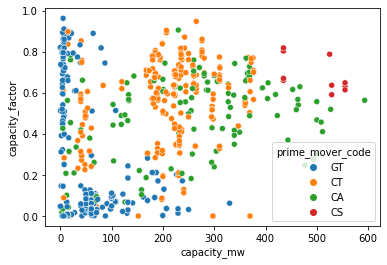

In [27]:
sns.scatterplot(data=mcoe_filt, x='capacity_mw',y='capacity_factor',hue='prime_mover_code')

In [55]:
df_stat = pd.DataFrame()
df_stat = mcoe_filt[mcoe_filt.prime_mover_code == 'GT'][['capacity_mw']].describe().rename(columns={'capacity_mw': 'GT'})
ct_stat = mcoe_filt[mcoe_filt.prime_mover_code == 'CT'][['capacity_mw']].describe().rename(columns={'capacity_mw': 'CT'})
ca_stat = mcoe_filt[mcoe_filt.prime_mover_code == 'CA'][['capacity_mw']].describe().rename(columns={'capacity_mw': 'CA'})
cs_stat = mcoe_filt[mcoe_filt.prime_mover_code == 'CS'][['capacity_mw']].describe().rename(columns={'capacity_mw': 'CS'})
df_stat = pd.concat([df_stat, ct_stat, ca_stat, cs_stat], axis=1)

In [56]:
df_stat

,GT,CT,CA,CS
count,331.000000,236.000000,122.000000,10.000000
mean,65.666465,205.035593,255.069672,498.800000
std,63.651964,97.184351,162.423054,56.043237
min,0.100000,5.500000,1.000000,435.000000
25%,7.350000,179.000000,127.025000,435.000000
50%,60.500000,222.700000,260.050000,527.000000
75%,100.000000,265.000000,361.900000,548.500000
max,330.000000,376.600000,663.900000,555.000000


### Codes
- GT: gas turbine
- CT: combined cycle combustion turbine
- CA: combined cycle steam turbine
- CS: combined cycle Single-Shaft Combustion Turbine and Steam Turbine
### Simple rule to divide up categories
- GT: if capacity below 100

In [57]:
import copy

In [30]:
iso_df = pd.read_csv('DBCP/data/active_iso_projects.csv')

In [66]:
df = copy.deepcopy(iso_df)
df = df[(df.resource == 'Gas') & (df.interconnection_status_lbnl == 'In Progress')]

In [67]:
df['prime_mover_inferred'] = 'GT'
df['prime_mover_inferred'] = df['prime_mover_inferred'].where(df['capacity_mw'] <= 100, 'CT')
df

,project_id,county,state,state_id_fips,county_id_fips,date_proposed_raw,developer,entity,interconnection_status_lbnl,interconnection_status_raw,...,days_in_queue,queue_date_raw,year_operational,date_withdrawn_raw,withdrawl_reason,year_withdrawn,date_withdrawn,resource,capacity_mw,prime_mover_inferred
47,41,grays harbor,WA,53.0,53027.0,01jan2020,NaN,PSE,In Progress,Facilities Study,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,255.0,CT
50,44,winfield,KS,20.0,NaN,6/1/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,58.0,GT
63,54,anderson,TX,48.0,48001.0,06/01/2022,Castleman Power,ERCOT,In Progress,"SS Completed, FIS Completed, No IA",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,200.0,CT
129,114,rutherford,NC,37.0,37161.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,602.0,CT
216,194,plattsmouth,NE,31.0,NaN,5/31/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,57.0,GT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967,5428,yellowstone,MT,30.0,30111.0,01jan2023,NaN,NWE,In Progress,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,175.0,CT
6039,5490,person,NC,37.0,37145.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,1350.0,CT
6049,5498,maricopa,AZ,4.0,4013.0,6/1/2024,NaN,APS,In Progress,SIS FaS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,900.0,CT
6267,2104,NaN,NaN,NaN,NaN,01jun2021,NaN,SEC,In Progress,System Impact,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gas,1148.0,CT


In [90]:
# source https://www.eia.gov/electricity/annual/html/epa_08_02.html
gt_hr = 11069
cc_hr = 7604
df['heat_rate_btu_per_kwh'] = gt_hr
df['heat_rate_btu_per_kwh'] = df['heat_rate_btu_per_kwh'].where(df['prime_mover_inferred'] == 'GT', cc_hr)
df

,project_id,county,state,state_id_fips,county_id_fips,date_proposed_raw,developer,entity,interconnection_status_lbnl,interconnection_status_raw,...,queue_date_raw,year_operational,date_withdrawn_raw,withdrawl_reason,year_withdrawn,date_withdrawn,resource,capacity_mw,prime_mover_inferred,heat_rate_btu_per_kwh
47,41,grays harbor,WA,53.0,53027.0,01jan2020,NaN,PSE,In Progress,Facilities Study,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,255.0,CT,7604
50,44,winfield,KS,20.0,NaN,6/1/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,58.0,GT,11069
63,54,anderson,TX,48.0,48001.0,06/01/2022,Castleman Power,ERCOT,In Progress,"SS Completed, FIS Completed, No IA",...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,200.0,CT,7604
129,114,rutherford,NC,37.0,37161.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,602.0,CT,7604
216,194,plattsmouth,NE,31.0,NaN,5/31/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,57.0,GT,11069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967,5428,yellowstone,MT,30.0,30111.0,01jan2023,NaN,NWE,In Progress,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,175.0,CT,7604
6039,5490,person,NC,37.0,37145.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,1350.0,CT,7604
6049,5498,maricopa,AZ,4.0,4013.0,6/1/2024,NaN,APS,In Progress,SIS FaS,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,900.0,CT,7604
6267,2104,NaN,NaN,NaN,NaN,01jun2021,NaN,SEC,In Progress,System Impact,...,NaN,NaN,NaN,NaN,NaN,NaN,Gas,1148.0,CT,7604


In [93]:
# Source: https://github.com/grgmiller/emission-factors
# unit kg CO2e/mmbtu of fuel
gas_emission_factor = 53.08
mmbtu_per_btu = 1/1000000
df['kg_co2e_emission_per_kwh'] = df['heat_rate_btu_per_kwh'] * mmbtu_per_btu * gas_emission_factor

In [94]:
df

,project_id,county,state,state_id_fips,county_id_fips,date_proposed_raw,developer,entity,interconnection_status_lbnl,interconnection_status_raw,...,year_operational,date_withdrawn_raw,withdrawl_reason,year_withdrawn,date_withdrawn,resource,capacity_mw,prime_mover_inferred,heat_rate_btu_per_kwh,kg_co2e_emission_per_kwh
47,41,grays harbor,WA,53.0,53027.0,01jan2020,NaN,PSE,In Progress,Facilities Study,...,NaN,NaN,NaN,NaN,NaN,Gas,255.0,CT,7604,0.403620
50,44,winfield,KS,20.0,NaN,6/1/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,NaN,Gas,58.0,GT,11069,0.587543
63,54,anderson,TX,48.0,48001.0,06/01/2022,Castleman Power,ERCOT,In Progress,"SS Completed, FIS Completed, No IA",...,NaN,NaN,NaN,NaN,NaN,Gas,200.0,CT,7604,0.403620
129,114,rutherford,NC,37.0,37161.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,NaN,Gas,602.0,CT,7604,0.403620
216,194,plattsmouth,NE,31.0,NaN,5/31/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,NaN,Gas,57.0,GT,11069,0.587543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967,5428,yellowstone,MT,30.0,30111.0,01jan2023,NaN,NWE,In Progress,Active,...,NaN,NaN,NaN,NaN,NaN,Gas,175.0,CT,7604,0.403620
6039,5490,person,NC,37.0,37145.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,NaN,Gas,1350.0,CT,7604,0.403620
6049,5498,maricopa,AZ,4.0,4013.0,6/1/2024,NaN,APS,In Progress,SIS FaS,...,NaN,NaN,NaN,NaN,NaN,Gas,900.0,CT,7604,0.403620
6267,2104,NaN,NaN,NaN,NaN,01jun2021,NaN,SEC,In Progress,System Impact,...,NaN,NaN,NaN,NaN,NaN,Gas,1148.0,CT,7604,0.403620


### Estimating Capacity Factor

In [97]:
from sklearn.linear_model import LinearRegression

In [105]:
mcoe_filt = mcoe_filt.dropna()

In [111]:
X = mcoe_filt[['capacity_mw', 'utility_id_eia']].to_numpy()
y = mcoe_filt['capacity_factor'].to_numpy()
reg = LinearRegression().fit(X, y)

In [112]:
reg.score(X, y)

0.10955164026640907

In [113]:
reg.coef_

array([7.19387087e-04, 1.16046608e-06])

In [118]:
gt = mcoe_filt[mcoe_filt.prime_mover_code == 'GT']
cc = mcoe_filt[~(mcoe_filt.prime_mover_code == 'GT')]

<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_factor'>

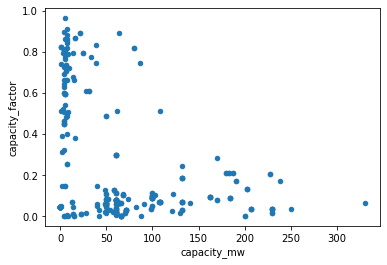

In [117]:
gt.plot(kind='scatter', x='capacity_mw', y='capacity_factor')

<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_factor'>

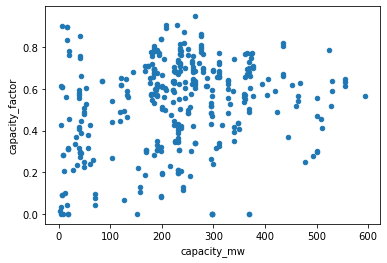

In [119]:
cc.plot(kind='scatter', x='capacity_mw', y='capacity_factor')

### Excluding location for now
- GT: two different values - one is average for capacity < 40 MW, second is average for capacity > 40 MW and < 100 MW
- CC: Just one average capacity_factor

In [127]:
small_gt_cf = gt[gt.capacity_mw < 40]['capacity_factor'].mean()
big_gt_cf = gt[(gt.capacity_mw < 100) & (gt.capacity_mw > 40)]['capacity_factor'].mean()
cc_cf = cc['capacity_factor'].mean()
small_gt_cf, big_gt_cf, cc_cf

(0.44248907302281965, 0.09830628059791548, 0.5243628996620433)

In [125]:
gt[(gt.capacity_mw < 100) & (gt.capacity_mw > 40)]['capacity_factor'].mean()

0.09830628059791548

In [129]:
df['capacity_factor_estimated'] = small_gt
df['capacity_factor_estimated'] = df['capacity_factor_estimated'].where(df['capacity_mw'] < 40, big_gt_cf)
df['capacity_factor_estimated'] = df['capacity_factor_estimated'].where(df['prime_mover_inferred'] == 'GT', cc_cf)
df

,project_id,county,state,state_id_fips,county_id_fips,date_proposed_raw,developer,entity,interconnection_status_lbnl,interconnection_status_raw,...,date_withdrawn_raw,withdrawl_reason,year_withdrawn,date_withdrawn,resource,capacity_mw,prime_mover_inferred,heat_rate_btu_per_kwh,kg_co2e_emission_per_kwh,capacity_factor_estimated
47,41,grays harbor,WA,53.0,53027.0,01jan2020,NaN,PSE,In Progress,Facilities Study,...,NaN,NaN,NaN,NaN,Gas,255.0,CT,7604,0.403620,0.524363
50,44,winfield,KS,20.0,NaN,6/1/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,Gas,58.0,GT,11069,0.587543,0.098306
63,54,anderson,TX,48.0,48001.0,06/01/2022,Castleman Power,ERCOT,In Progress,"SS Completed, FIS Completed, No IA",...,NaN,NaN,NaN,NaN,Gas,200.0,CT,7604,0.403620,0.524363
129,114,rutherford,NC,37.0,37161.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,Gas,602.0,CT,7604,0.403620,0.524363
216,194,plattsmouth,NE,31.0,NaN,5/31/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,Gas,57.0,GT,11069,0.587543,0.098306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967,5428,yellowstone,MT,30.0,30111.0,01jan2023,NaN,NWE,In Progress,Active,...,NaN,NaN,NaN,NaN,Gas,175.0,CT,7604,0.403620,0.524363
6039,5490,person,NC,37.0,37145.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,Gas,1350.0,CT,7604,0.403620,0.524363
6049,5498,maricopa,AZ,4.0,4013.0,6/1/2024,NaN,APS,In Progress,SIS FaS,...,NaN,NaN,NaN,NaN,Gas,900.0,CT,7604,0.403620,0.524363
6267,2104,NaN,NaN,NaN,NaN,01jun2021,NaN,SEC,In Progress,System Impact,...,NaN,NaN,NaN,NaN,Gas,1148.0,CT,7604,0.403620,0.524363


In [131]:
df['MWh'] = df['capacity_mw'] * df['capacity_factor_estimated']

In [132]:
kwh_per_mwh = 1000
df['kg_co2e'] = df['kg_co2e_emission_per_kwh'] * kwh_per_mwh * df['MWh']
df

,project_id,county,state,state_id_fips,county_id_fips,date_proposed_raw,developer,entity,interconnection_status_lbnl,interconnection_status_raw,...,year_withdrawn,date_withdrawn,resource,capacity_mw,prime_mover_inferred,heat_rate_btu_per_kwh,kg_co2e_emission_per_kwh,capacity_factor_estimated,MWh,kg_co2e
47,41,grays harbor,WA,53.0,53027.0,01jan2020,NaN,PSE,In Progress,Facilities Study,...,NaN,NaN,Gas,255.0,CT,7604,0.403620,0.524363,133.712539,53969.097946
50,44,winfield,KS,20.0,NaN,6/1/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,Gas,58.0,GT,11069,0.587543,0.098306,5.701764,3350.028950
63,54,anderson,TX,48.0,48001.0,06/01/2022,Castleman Power,ERCOT,In Progress,"SS Completed, FIS Completed, No IA",...,NaN,NaN,Gas,200.0,CT,7604,0.403620,0.524363,104.872580,42328.704272
129,114,rutherford,NC,37.0,37161.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,Gas,602.0,CT,7604,0.403620,0.524363,315.666466,127409.399857
216,194,plattsmouth,NE,31.0,NaN,5/31/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,Gas,57.0,GT,11069,0.587543,0.098306,5.603458,3292.269831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967,5428,yellowstone,MT,30.0,30111.0,01jan2023,NaN,NWE,In Progress,Active,...,NaN,NaN,Gas,175.0,CT,7604,0.403620,0.524363,91.763507,37037.616238
6039,5490,person,NC,37.0,37145.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,Gas,1350.0,CT,7604,0.403620,0.524363,707.889915,285718.753833
6049,5498,maricopa,AZ,4.0,4013.0,6/1/2024,NaN,APS,In Progress,SIS FaS,...,NaN,NaN,Gas,900.0,CT,7604,0.403620,0.524363,471.926610,190479.169222
6267,2104,NaN,NaN,NaN,NaN,01jun2021,NaN,SEC,In Progress,System Impact,...,NaN,NaN,Gas,1148.0,CT,7604,0.403620,0.524363,601.968609,242966.762519


In [134]:
df.to_csv('DBCP/outputs/emissions_estimates_iso_queue.csv', index=False)

### Heat rate table by year - didn't use

In [80]:
avg_heat_rate = pd.DataFrame({'year': np.arange(2010, 2021, 1)})

In [81]:
# source https://www.eia.gov/electricity/annual/html/epa_08_02.html
gt = [11590, 11569, 11499, 11371, 11378, 11302, 11214, 11176, 11138, 11098, 11069]
cc = [7619, 7603, 7615, 7667, 7658, 7655, 7652, 7649, 7627, 7633, 7604]
avg_heat_rate['gas_turbine_btu_per_kwh'] = gt
avg_heat_rate['combined_cycle_btu_per_kwh'] = cc
avg_heat_rate

,year,gas_turbine_btu_per_kwh,combined_cycle_btu_per_kwh
0,2010,11590,7619
1,2011,11569,7603
2,2012,11499,7615
3,2013,11371,7667
4,2014,11378,7658
5,2015,11302,7655
6,2016,11214,7652
7,2017,11176,7649
8,2018,11138,7627
9,2019,11098,7633


In [89]:
df.merge(avg_heat_rate, how='left', left_on='year_proposed', right_on='year')

,project_id,county,state,state_id_fips,county_id_fips,date_proposed_raw,developer,entity,interconnection_status_lbnl,interconnection_status_raw,...,date_withdrawn_raw,withdrawl_reason,year_withdrawn,date_withdrawn,resource,capacity_mw,prime_mover_inferred,year,gas_turbine_btu_per_kwh,combined_cycle_btu_per_kwh
0,41,grays harbor,WA,53.0,53027.0,01jan2020,NaN,PSE,In Progress,Facilities Study,...,NaN,NaN,NaN,NaN,Gas,255.0,CT,2020.0,11069.0,7604.0
1,44,winfield,KS,20.0,NaN,6/1/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,Gas,58.0,GT,NaN,NaN,NaN
2,54,anderson,TX,48.0,48001.0,06/01/2022,Castleman Power,ERCOT,In Progress,"SS Completed, FIS Completed, No IA",...,NaN,NaN,NaN,NaN,Gas,200.0,CT,NaN,NaN,NaN
3,114,rutherford,NC,37.0,37161.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,Gas,602.0,CT,NaN,NaN,NaN
4,194,plattsmouth,NE,31.0,NaN,5/31/2023,NaN,SPP,In Progress,DISIS STAGE,...,NaN,NaN,NaN,NaN,Gas,57.0,GT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5428,yellowstone,MT,30.0,30111.0,01jan2023,NaN,NWE,In Progress,Active,...,NaN,NaN,NaN,NaN,Gas,175.0,CT,NaN,NaN,NaN
196,5490,person,NC,37.0,37145.0,NaN,NaN,Duke,In Progress,System Impact Study - In Progress,...,NaN,NaN,NaN,NaN,Gas,1350.0,CT,NaN,NaN,NaN
197,5498,maricopa,AZ,4.0,4013.0,6/1/2024,NaN,APS,In Progress,SIS FaS,...,NaN,NaN,NaN,NaN,Gas,900.0,CT,NaN,NaN,NaN
198,2104,NaN,NaN,NaN,NaN,01jun2021,NaN,SEC,In Progress,System Impact,...,NaN,NaN,NaN,NaN,Gas,1148.0,CT,NaN,NaN,NaN
